# 7.1 Assessing the impacts of interventions

In Tutorial 5.2 you saw how to add interventions to the model. In this tutorial you will expand on this idea by comparing the impact of two different interventions for a model of measles.

## Problem 1

First, define a treatment intervention that can be given to people as soon as they start to exhibit symptoms (i.e., as soon as they are infected). For people who receive the treatment, their mean duration of infection will be 5 days.

Next, define a treatment intervention that can be given to people a certain number of days after they are exposed. People who receive this treatment will no longer be transmissible.

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.09 s)  ———————————————————— 2%


/Users/robynstuart/Documents/git/starsim/starsim/disease.py:58: RuntimeWarning: 
Beta not supplied for disease "measles"; defaulting to 1
  ss.warn(msg)


  Running 10.0 (10/51) (0.36 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.50 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (0.66 s)  ••••••••••••———————— 61%
  Running 40.0 (40/51) (0.80 s)  ••••••••••••••••———— 80%
  Running 50.0 (50/51) (1.07 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.07 s)  ———————————————————— 2%
  Running 10.0 (10/51) (0.35 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.55 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (1.39 s)  ••••••••••••———————— 61%
  Running 40.0 (40/51) (1.69 s)  ••••••••••••••••———— 80%
  Running 50.0 (50/51) (1.96 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.05 s)  ———————————————————— 2%
  Running 10.0 (10/51) (0.22 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.39 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (0.61 s)  ••••••••••••———————— 61%
  Running 40.0 (40/51) (0.76 s)  ••••••••••••••••———— 80%
  

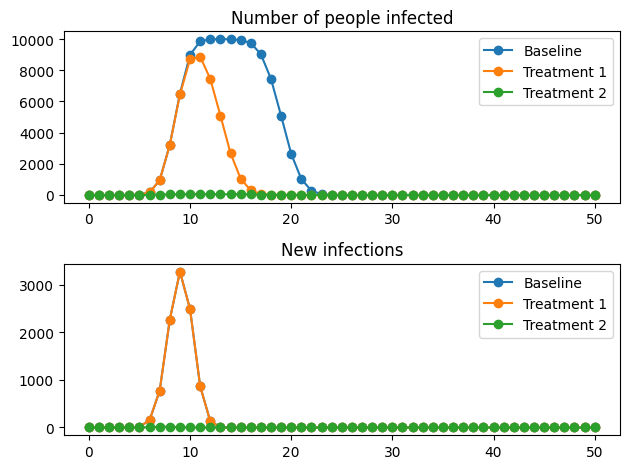

Averted by treatment 1: 59924.0
Averted by treatment 2: 104459.0


In [3]:
import numpy as np # Math
import sciris as sc # Utilities
import pylab as pl # Plotting
import starsim as ss # ABM


class Treatment1(ss.Intervention):  # Create a new, generic treatment intervention

    def __init__(self, prob=0.5, mean_dur_infection=5):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of vaccination
        self.dur_infection = ss.normal(mean_dur_infection, 1)  # Store the duration of infection

    def apply(self, sim):
        measles = sim.diseases.measles

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[measles.ti_infected == sim.ti]  # People are eligible for treatment if they have just started exhibiting symptoms
        n_eligible = len(eligible_ids) # Number of people who are eligible

        # Define who receives treatment
        is_treated = np.random.rand(n_eligible) < self.p  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
        treat_ids = eligible_ids[is_treated]  # Pull out the IDs for the people receiving the treatment

        # Treated people will have a new disease progression
        dur_inf = self.dur_infection.rvs(treat_ids)  # Sample duration of infection by generating random variables (RVS) drawn from the distribution of durations

        # Determine who dies and who recovers and when
        will_die = measles.pars.p_death.rvs(treat_ids)  # Sample probability of dying
        dead_uids = treat_ids[will_die]  # Pull out the IDs of people who die
        recover_uids = treat_ids[~will_die]  # Pull out the IDs of people who recovery
        measles.ti_dead[dead_uids] = measles.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt  # Set the time of death
        measles.ti_recovered[recover_uids] = measles.ti_infected[recover_uids] + dur_inf[~will_die] / sim.dt  # Set the time of recovery


class Treatment2(ss.Intervention):
    def __init__(self, prob=1, rel_trans=0, treat_delay=0):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of vaccination
        self.rel_trans = rel_trans  # Relative transmissibility of treated people
        self.treat_delay = treat_delay  # Delay between exposure and receiving treatment

    def apply(self, sim):
        measles = sim.diseases.measles

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[(measles.ti_exposed - self.treat_delay) == sim.ti]  # People are eligible for treatment after a delay of treat_delay days after they are exposed
        n_eligible = len(eligible_ids)  # Number of eligible people

        # Define who receives treatment
        is_treated = np.random.rand(n_eligible) < self.p  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
        treat_ids = eligible_ids[is_treated]  # Pull out the IDs for the people receiving the treatment

        # Treated people will have a reduced relative transmissibility
        measles.rel_trans[treat_ids] = self.rel_trans


def make_run_sim(treat_delay=0):

    # Make the treatments
    t1 = Treatment1()  # Create the specific treatment 1 
    t2 = Treatment2(treat_delay=treat_delay)  # Create the specific treatment 2 with a delay

    # Make the sim parameters
    pars = dict(start=0, end=50, dt=1.0, diseases='measles', networks='random')  # Define the parameters of the simulation

    # Define "baseline" and "intervention" sims without any treatment, and with treatment 1 and treatment 2
    baseline = ss.Sim(pars)
    t1sim = ss.Sim(pars, interventions=t1)
    t2sim = ss.Sim(pars, interventions=t2)

    # Run the three simulations
    baseline.run()
    t1sim.run()
    t2sim.run()

    # Pull out results to plot
    tvec = baseline.yearvec
    n_inf_base = baseline.results.measles.n_infected
    n_inf_t1 = t1sim.results.measles.n_infected
    n_inf_t2 = t2sim.results.measles.n_infected

    new_inf_base = baseline.results.measles.new_infections
    new_inf_t1 = t1sim.results.measles.new_infections
    new_inf_t2 = t2sim.results.measles.new_infections

    # Create the figure
    pl.figure()

    # Plot number of people infected
    pl.subplot(2,1,1)  # Create the first panel in the plot
    pl.title('Number of people infected')
    pl.plot(tvec, n_inf_base, 'o-', label='Baseline')  # Plot baseline
    pl.plot(tvec, n_inf_t1, 'o-', label='Treatment 1')  # Plot treatment 1
    pl.plot(tvec, n_inf_t2, 'o-', label='Treatment 2')  # Plot treatment 2
    pl.legend()

    # Plot number of new infections
    pl.subplot(2,1,2) # Create the second panel in the plot
    pl.title('New infections')
    pl.plot(tvec, new_inf_base, 'o-', label='Baseline') # Plot baseline
    pl.plot(tvec, new_inf_t1, 'o-', label='Treatment 1') # Plot treatment 1
    pl.plot(tvec, new_inf_t2, 'o-', label='Treatment 2') # Plot treatment 2
    pl.legend()

    sc.figlayout()
    pl.show()

    # Calculate and display the number of infections averted
    averted_by_t1 = n_inf_base.sum() - n_inf_t1.sum()
    averted_by_t2 = n_inf_base.sum() - n_inf_t2.sum()
    print(f'Averted by treatment 1: {averted_by_t1}')
    print(f'Averted by treatment 2: {averted_by_t2}')


# Make, run, and plot the simulation
make_run_sim()


## Problem 2

Explore the properties of the treatments:

- Treatment 2 is administered with a delay (`treat_delay`). Try running the intervention with `treat_delay = 1` and interpret your result.
- What recommendation would you make about the two treatments?

## Solution 2

### Explore the properties of the treatments

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.11 s)  ———————————————————— 2%
  Running 10.0 (10/51) (0.54 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.68 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (0.92 s)  ••••••••••••———————— 61%
  Running 40.0 (40/51) (1.06 s)  ••••••••••••••••———— 80%
  Running 50.0 (50/51) (1.22 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.05 s)  ———————————————————— 2%
  Running 10.0 (10/51) (0.26 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.41 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (0.58 s)  ••••••••••••———————— 61%
  Running 40.0 (40/51) (0.73 s)  ••••••••••••••••———— 80%
  Running 50.0 (50/51) (0.91 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/51) (0.05 s)  ———————————————————— 2%
  Running 10.0 (10/51) (0.36 s)  ••••———————————————— 22%
  Running 20.0 (20/51) (0.51 s)  ••••••••———————————— 41%
  Running 30.0 (30/51) (0.6

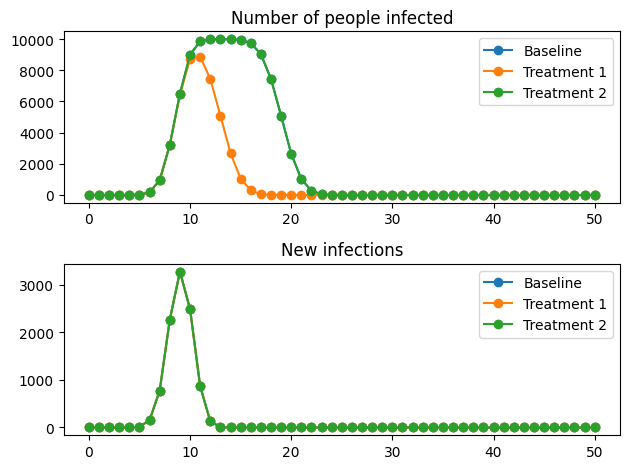

Averted by treatment 1: 59924.0
Averted by treatment 2: 0.0


In [4]:
make_run_sim(treat_delay=1)